# Supplemental Methods & Results

Gaylen Fronk  
Invalid Date

## Supplemental Methods

### AIM 1 analytic strategy

#### Model building

We built supplemental models to predict biologically confirmed, 7-day point-prevalence abstinence at 12 weeks and 26 weeks. The 12-week outcome represents the end-of-treatment and has been used as a primary outcome for this reason in extant precision mental health research (e.g., @chenGeneticVariantCHRNA52020). The 26-week (6 month) outcome is a typical outcome used in smoking cessation research to evaluate treatments because it serves as a feasible proxy for long-term abstinence \[@fioreClinicalPracticeGuideline2008\].

We followed our model fitting, selection, and evaluation procedures from the main manuscript to fit these additional models. Briefly, we considered model configurations that used the GLMNet statistical algorithm and varied by hyperparameter values and feature sets. We used nested cross-validation with 1 repeat of 10-fold cross-validation in the inner loop and 3 repeats of 10-fold cross-validation in the outer loop.

#### Metrics

Models were evaluated using area under the Receiver Operating Characteristic Curve (auROC) from held-out folds (test sets) in the outer loop. We used the same satisficing criterion of retaining a median of 50 or more treatment interactions across inner folds. We opted to keep this threshold consistent across models, though we confirmed that this value was still reasonable based on inner fold distributions and number of remaining model configurations for selection in each outer fold.

#### Bayesian analysis of model performance

We followed our same procedure to evaluate model performance using Bayesian hierarchical linear models. We estimated posterior probability distributions and 95% Bayesian credible intervals (CIs) following recommendations from the tidymodels team \[@kuhnTidyposteriorBayesianAnalysis2022\]. We report the 95% (equal-tailed) Bayesian CIs from the posterior probability distributions for our models’ auROCs. If 95% Bayesian CIs do not include 0.5 (chance performance), we can conclude that the model performs better than chance.

We also examined whether our models’ performance differed as a function of prediction outcome. We regressed the auROCs (logit transformed) from the 30 test sets as a function of prediction outcome (4 week, 12 week, 26 week) with two random intercepts for repeat and fold within repeat. We report the 95% (equal-tailed) Bayesian CIs from the posterior probability distributions for the difference in performance between our models. If the 95% Bayesian CIs around the model contrast do not include 0, we can conclude that the models’ performance differs by prediction outcome.

### AIM 2 analytic strategy

We followed our methods from the main manuscript to select final model configurations, identify model-predicted best treatment using leave-one-out cross-validation, categorize treatment matching, and evaluate clinical benefit of these treatment selection models.

Although we did not preregister completing these analyses with 12-week and 26-week models, we followed our preregistered analyses. Like in our primary analyses, we used log base 2 for our log transformation of week instead of our preregistered log base *e* due to convergence issues.

## Supplemental Results

### AIM 1 results: Prediction models

#### Model performance

We selected the best model configurations using auROCs from the *validation sets* (among models that met our satisficing metric of a median of at least 50 retained treatment interaction features in inner folds). We evaluated these best model configurations using *test set* performance. Test set performance for the 4-week model appears in the main manuscript. The median auROC across the 30 test sets for the 12-week model was 0.665 (IQR = 0.628 - 0.697, range = 0.535 - 0.788). The median auROC across the 30 test sets for the 26-week model was 0.629 (IQR = 0.573 - 0.658, range = 0.474 - 0.743). The single, concatenated ROC curve and the 30 individual ROC curves (one per held-out fold) for the 4-, 12-, and 26-week models appear in Supplemental Figure 1.

``` python
fig_roc_all <- fig_roc_all_wk4 + fig_roc_all_wk12 + fig_roc_all_wk26 + 
  plot_layout(ncol = 1) +
  plot_annotation(tag_levels = "A")

fig_roc_all
```

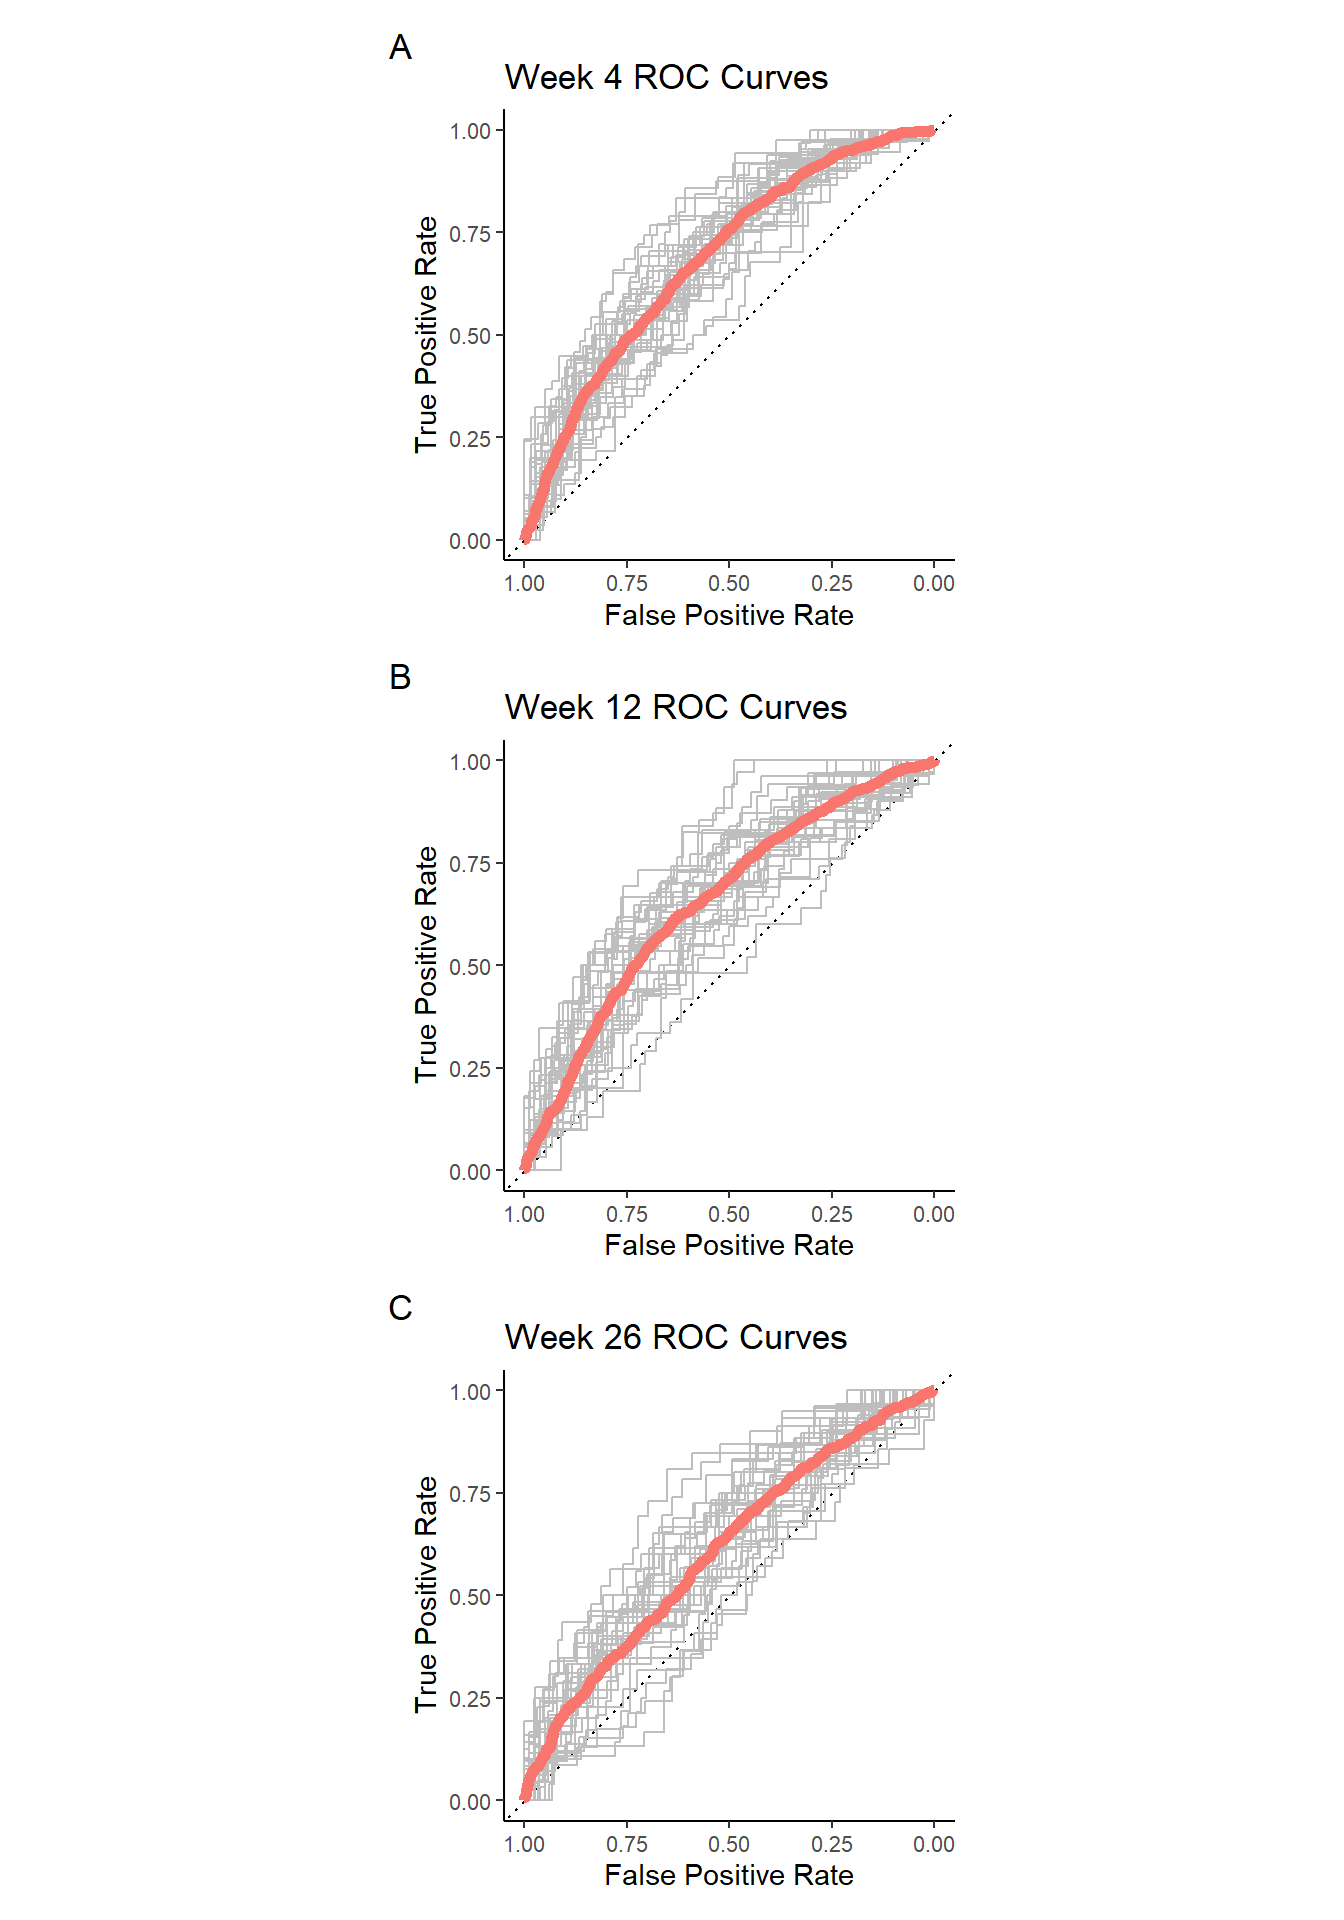

We used the 30 test set auROCs to estimate the posterior probability distribution for the auROC of these models. The median auROC from the posterior distribution was 0.663 \[Bayesian CI: 0.640 - 0.685\] for the 12-week model and 0.620 \[Bayesian CI: 0.596 - 0.644\] for the 26-week model. These results suggest both models have predictive signal as the CIs did not contain 0.5 (chance performance). Supplemental Figure 2 displays the posterior probability distributions for these models’ auROCs alongside the posterior probability distribution for the 4-week model’s auROCs.

``` python
fig_posteriors <- pp_tidy |> 
  mutate(model = factor(model, levels = c("week_4", "week_12", "week_26"),
                        labels = c("Week 4", "Week 12", "Week 26"))) |> 
  ggplot() + 
  geom_histogram(aes(x = posterior, fill = model), color = "black", alpha = .4, 
                 bins = 30) +
  geom_segment(mapping = aes(y = y + 100, yend = y - 100, x = mean, xend = mean,
                             color = model),
               data = ci) +
  geom_segment(mapping = aes(y = y, yend = y, 
                             x = lower, xend = upper, color = model),
               data = ci) +
  facet_wrap(~model, ncol = 1) +
  scale_y_continuous("Posterior Probability", breaks = c(0, 500, 1000)) +
  labs(
    x = "Area Under ROC Curve (auROC)",
    fill = "Model",
    color = "Model"
  )

fig_posteriors
```

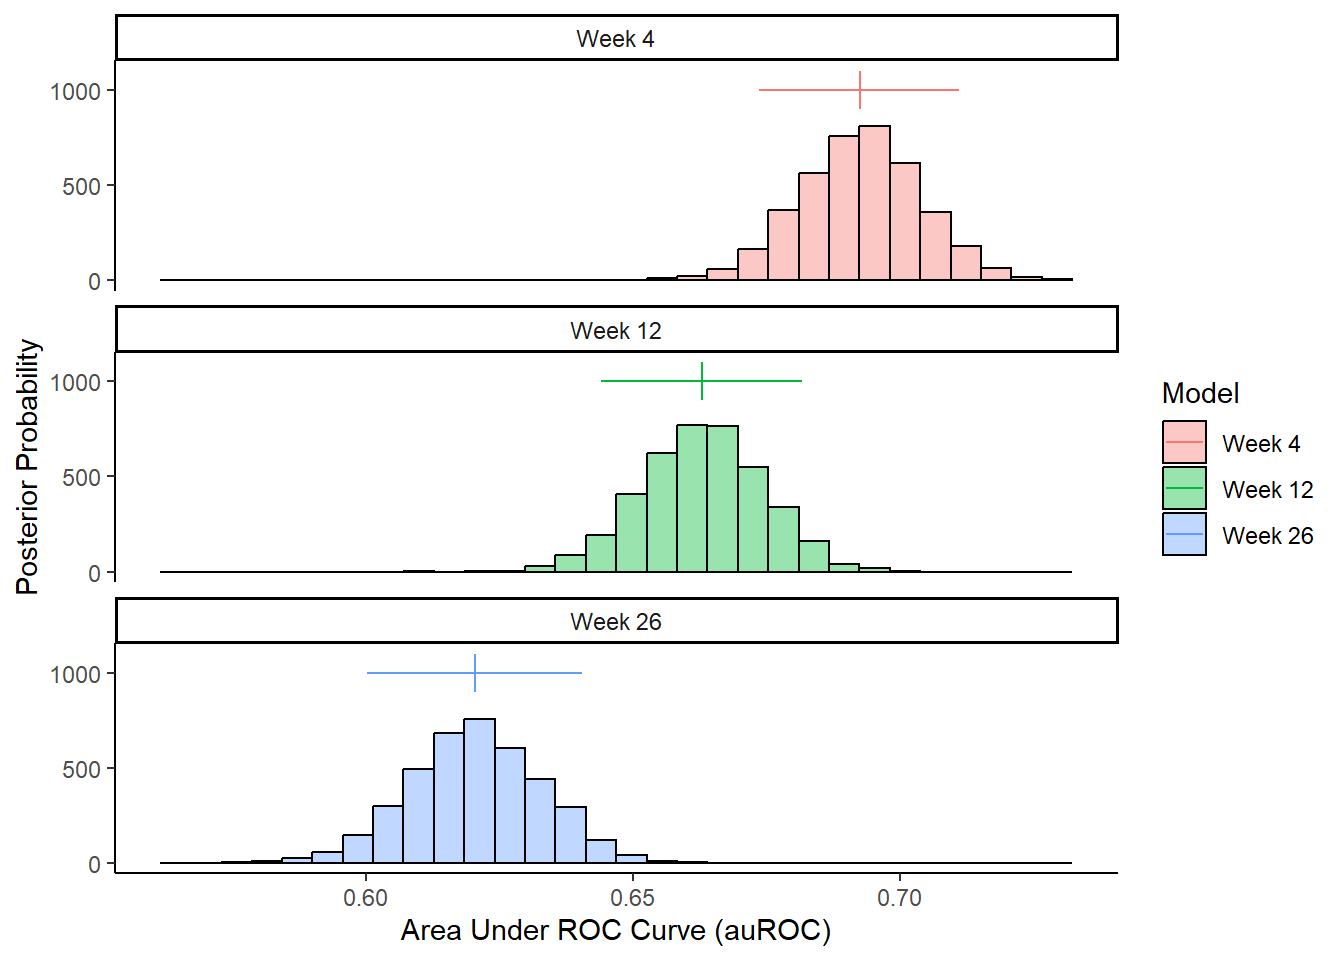

#### Model comparisons

We used the posterior probability distributions for the auROCs to compare the 4-, 12-, and 26-week models. The median increase in auROC for the 4- vs. 12-week model was 0.029 (95% CI = 0.010 - 0.049), yielding a probability of 99.8% that the 4-week model had superior performance. The median increase in auROC for the 4- vs. 26-week model was 0.072 (95% CI = 0.052 - 0.092), yielding a probability of 100% that the 4-week model had superior performance. The median increase in auROC for the 12- vs. 26-week model was 0.043 (95% CI = 0.022 - 0.064), yielding a probability of 100% that the 12-week model had superior performance. Supplemental Figure 3 presents histograms of the posterior probability distributions for these model contrasts.

``` python
fig_contrasts <- pp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(wk4_vs_wk26 = week_4 - week_26,
         wk4_vs_wk12 = week_4 - week_12,
         wk12_vs_wk26 = week_12 - week_26) |> 
  pivot_longer(cols = c(wk4_vs_wk12, wk4_vs_wk26, wk12_vs_wk26),
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast,
                           levels = c("wk4_vs_wk12", "wk4_vs_wk26", "wk12_vs_wk26"),
                           labels = c("Week 4 vs. Week 12",
                                      "Week 4 vs. Week 26",
                                      "Week 12 vs. Week 26"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black", alpha = .4, bins = 30) +
  geom_vline(xintercept = 0, color = "yellow", 
             linetype = "dashed", linewidth = 1) +
  geom_segment(mapping = aes(y = y+50, yend = y-50, 
                             x = mean, xend = mean, color = contrast), 
               data = ci_con) +
  geom_segment(mapping = aes(y = y, yend = y, 
                             x = lower, xend = upper, color = contrast), 
               data = ci_con) +
  facet_wrap(~contrast, ncol = 1) +
  labs(
    x = "Model Contrast for auROC",
    y = "Posterior Probability",
    fill = "Contrast",
    color = "Contrast"
  )

fig_contrasts
```

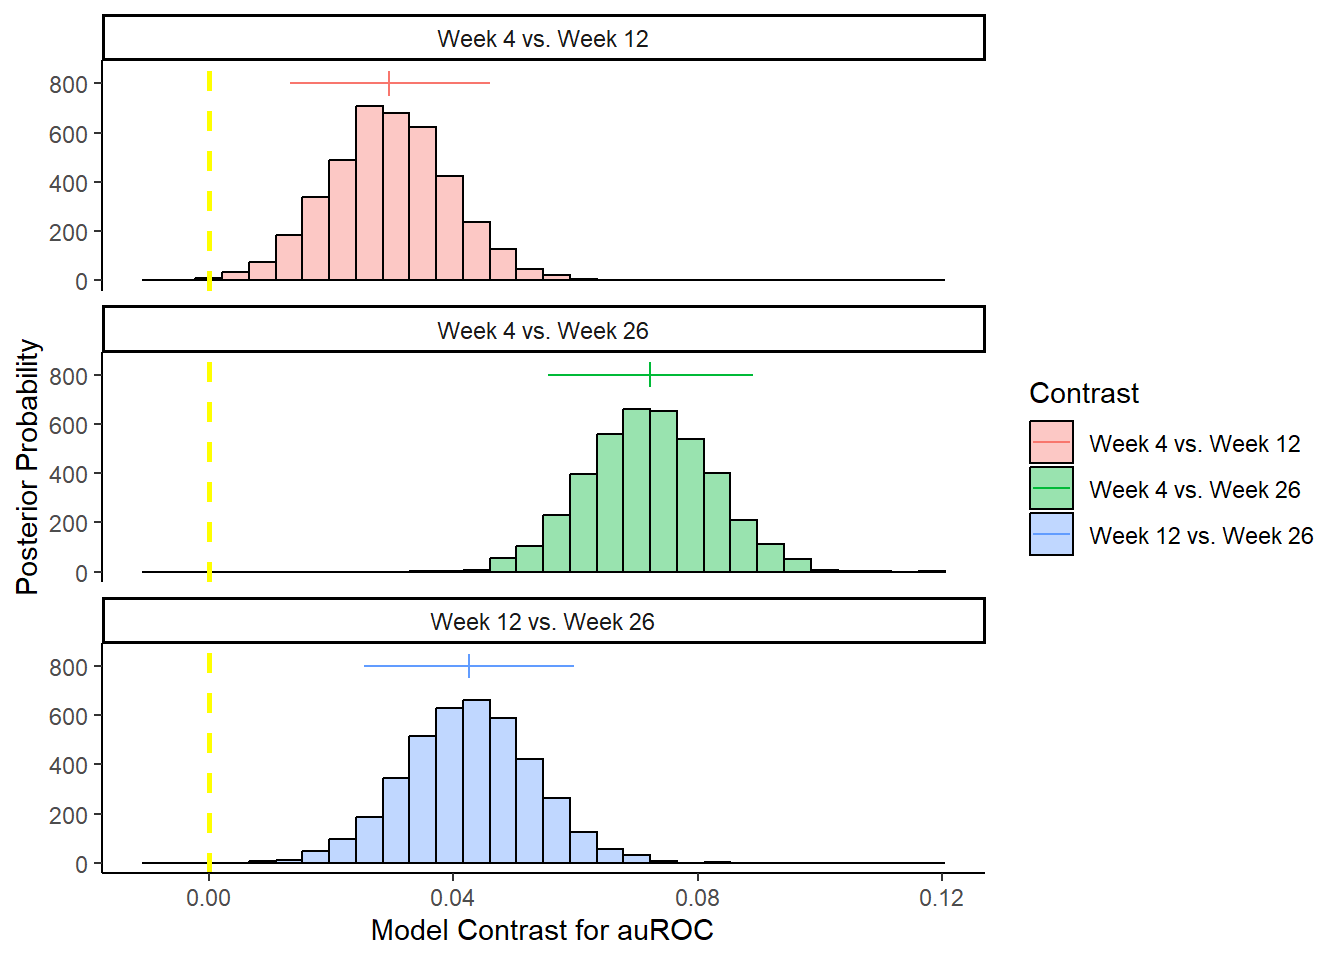

#### Model calibration

In Supplemental Figure 4, we display the calibration for the 12-week (Panel A) and 26-week (Panel B) models. Predicted lapse probabilities are binned (bin width = 10%) and plotted against the observed probability of abstinence for observations in that bin. If probabilities were perfectly calibrated, all bin means would fall on the dotted line (e.g., bin from 0 - 10 with an observed mean probability of 0.05, bin from 10 - 20 with an observed mean probability of 0.15).

This figure plots the probabilities from our held-out predictions (made with leave-one-out cross-validation) using the final selected model configuration for each individual for their original trial-assigned treatment against the observed trial abstinence rates. Probabilities were relatively well calibrated and ordinal in their relationship with the true probability of abstinence for both the 12- and 26-week models. Given this, these probabilities can provide precise predictions of treatment success that can be used for treatment selection.

``` python
fig_cal_supp <- (fig_cal_bins_12 / fig_cal_bins_26) +
  plot_layout(ncol = 1,
              heights = unit(c(3, 3), "in"),
              widths = unit(c(4, 4), "in")) +
  plot_annotation(tag_levels = "A")

fig_cal_supp
```

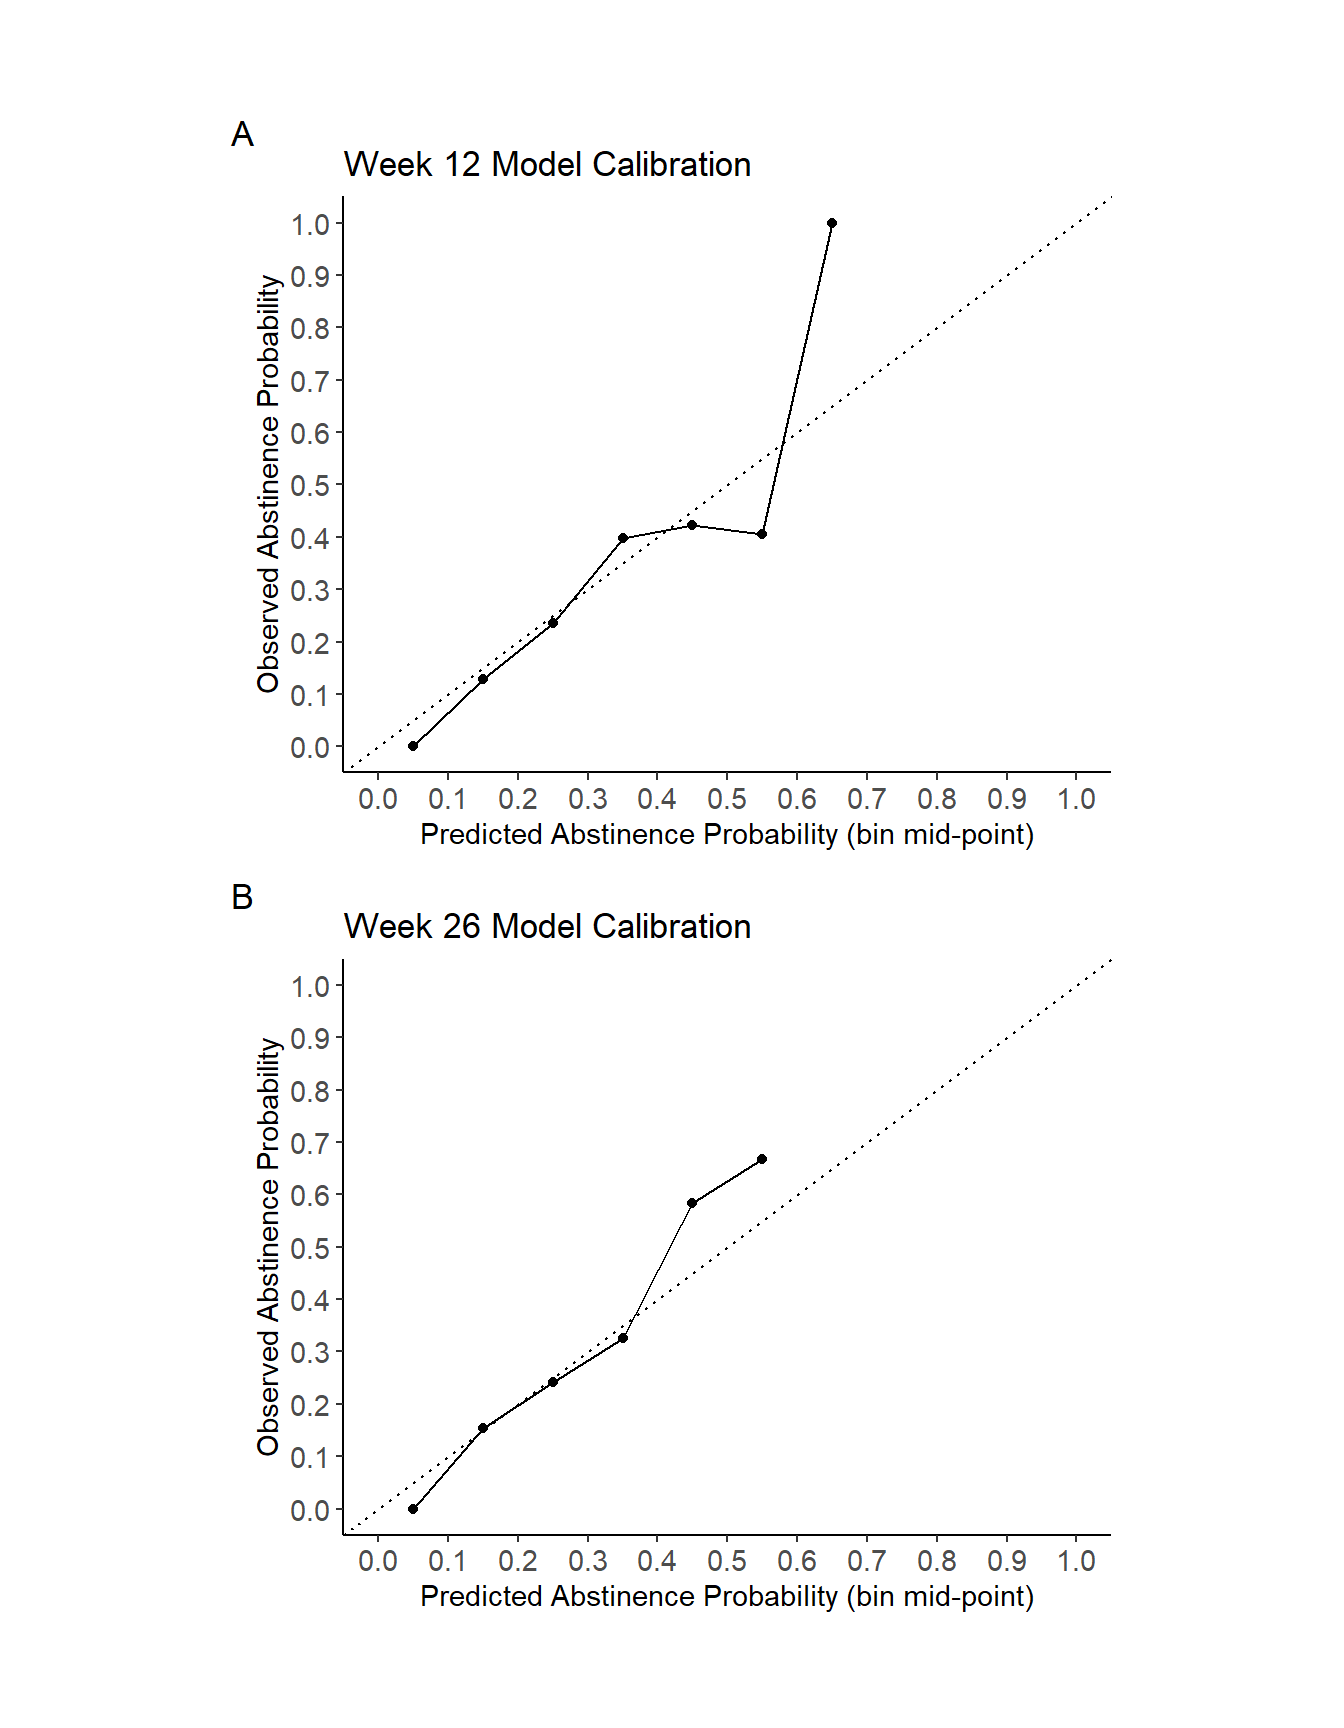

#### Model interpretation

The names of all retained features and their parameter estimates from the final 4-week model appear in Supplemental Table 1. Retained features for the 4-week model are discussed in detail in the main manuscript.

``` python
retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

knitr::kable(retained_vars, digits = 4)
```

  -------------------------------------------------------------------------------------
  term                                                                         estimate
  -------------------------------------------------------------------------- ----------
  (Intercept)                                                                   -0.7492

  co                                                                            -0.1824

  race_ehr_white                                                                 0.1280

  treatment_combo_nrt_x_live_with_smoker_live_alone_or_only_with_partner         0.1076

  wisdm37_2_item_order                                                           0.1062

  motive_quit_order                                                              0.1041

  asi3_15_item_order                                                             0.0896

  wisdm37_30_item_order                                                         -0.0893

  longest_quit_order                                                             0.0836

  wsws_want_cig_24h_item_order                                                  -0.0769

  treatment_varenicline_x_live_with_smoker_live_alone_or_only_with_partner      -0.0722

  race_ehr_black_african_american                                               -0.0675

  shp_2_item_order                                                               0.0673

  dts_13_item_order                                                              0.0669

  treatment_combo_nrt_x_race_ehr_black_african_american                         -0.0663

  time_around_smokers_weekend_order                                             -0.0645

  life_satisfaction_order                                                        0.0615

  treatment_combo_nrt_x_wisdm37_22_item_order                                   -0.0607

  income_order                                                                   0.0557

  mfi_15_item_order                                                              0.0518

  mfi_9_item_order                                                              -0.0478

  treatment_combo_nrt_x_smoke_menthol_no                                         0.0468

  tot_quit_attempt                                                               0.0466

  wisdm37_5_item_order                                                          -0.0456

  important_to_quit_order                                                        0.0431

  treatment_patch_x_used_cigars_never_tried                                     -0.0428

  treatment_patch_x_close_smoke_friend_no                                       -0.0419

  treatment_combo_nrt_x_dts_5_item_order                                         0.0415

  wisdm37_27_item_order                                                         -0.0414

  smoke_menthol_yes                                                             -0.0403

  wisdm37_13_item_order                                                         -0.0389

  shp_9_item_order                                                               0.0384

  treatment_varenicline_x_asi3_15_item_order                                     0.0381

  wsws_unhappy_24h_item_order                                                   -0.0378

  wsws_5_item_order                                                              0.0366

  treatment_patch_x_used_cigars_tried                                            0.0354

  sip2r_2_item_order                                                            -0.0343

  treatment_patch_x_close_smoke_co_worker_yes                                    0.0336

  treatment_varenicline_x_mfi_6_item_order                                       0.0320

  treatment_varenicline_x_income_order                                           0.0317

  treatment_varenicline_x_spouse_smoke_no                                        0.0316

  wsws_18_item_order                                                            -0.0305

  treatment_combo_nrt_x_wisdm37_30_item_order                                   -0.0301

  marital_status_ehr_married                                                     0.0299

  treatment_combo_nrt_x_marital_status_ehr_divorced                             -0.0293

  treatment_combo_nrt_x_dsm5_6_item_no                                           0.0287

  treatment_varenicline_x_close_smoke_relative_no                               -0.0287

  sip2r_3_item_order                                                            -0.0277

  treatment_varenicline_x_dsm5_3_item_yes                                        0.0275

  treatment_varenicline_x_used_cigars_never_tried                                0.0259

  hdsm_tense                                                                    -0.0258

  treatment_combo_nrt_x_asi3_2_item_order                                       -0.0257

  treatment_combo_nrt_x_race_ehr_white                                           0.0251

  treatment_combo_nrt_x_marital_status_ehr_married                               0.0242

  wisdm37_18_item_order                                                         -0.0239

  treatment_combo_nrt_x_dsm5_10_item_yes                                        -0.0235

  dsm5_12_item_no                                                                0.0233

  dsm5_12_item_yes                                                              -0.0233

  treatment_patch_x_work_ban_no_smoking_allowed                                 -0.0232

  berlin_7_order                                                                -0.0232

  treatment_patch_x_wsws_crave_24h_item_order                                   -0.0226

  quit_success_30d_order                                                         0.0220

  treatment_combo_nrt_x_smoke_menthol_yes                                       -0.0218

  smoke_menthol_no                                                               0.0215

  dsm5_8_item_no                                                                 0.0215

  dsm5_8_item_yes                                                               -0.0215

  treatment_varenicline_x_psych_depression_yes                                   0.0214

  treatment_combo_nrt_x_wisdm37_19_item_order                                   -0.0213

  wisdm37_14_item_order                                                         -0.0211

  sip2r_12_item_order                                                           -0.0211

  hdsm_pain                                                                     -0.0208

  treatment_patch_x_wisdm37_26_item_order                                        0.0207

  treatment_varenicline_x_live_with_smoker_no                                    0.0204

  shp_14_item_order                                                              0.0202

  treatment_patch_x_close_smoke_friend_yes                                       0.0198

  wsws_20_item_order                                                            -0.0192

  wsws_9_item_order                                                             -0.0192

  time_around_smokers_order                                                     -0.0189

  treatment_varenicline_x_wisdm37_32_item_order                                 -0.0188

  shp_13_item_order                                                             -0.0182

  wisdm37_32_item_order                                                         -0.0175

  asi3_9_item_order                                                              0.0162

  wsws_angry_24h_item_order                                                     -0.0160

  used_cigars_use_regularly                                                     -0.0158

  treatment_combo_nrt_x_mfi_13_item_order                                        0.0150

  treatment_varenicline_x_berlin_7_order                                        -0.0146

  treatment_varenicline_x_used_cigars_tried                                     -0.0144

  treatment_varenicline_x_wisdm37_27_item_order                                 -0.0135

  psych_depression_no                                                           -0.0134

  psych_depression_yes                                                           0.0134

  wsws_stressed_24h_item_order                                                  -0.0127

  wsws_15_item_order                                                            -0.0126

  treatment_varenicline_x_close_smoke_relative_yes                               0.0124

  treatment_combo_nrt_x_ftnd_6_item_no                                           0.0123

  phq9_6_item_order                                                             -0.0120

  treatment_combo_nrt_x_live_with_smoker_yes                                    -0.0113

  wsws_12_item_order                                                            -0.0113

  used_chew_or_snuff_never_tried                                                 0.0110

  treatment_patch_x_marital_status_ehr_never_married                             0.0104

  treatment_patch_x_gender_ehr_female                                           -0.0103

  treatment_varenicline_x_wsws_constipation_24h_item_order                       0.0099

  treatment_combo_nrt_x_life_satisfaction_order                                  0.0099

  mfi_5_item_order                                                               0.0093

  marital_status_ehr_divorced                                                   -0.0088

  treatment_varenicline_x_dsm5_7_item_no                                        -0.0082

  shp_3_item_order                                                               0.0080

  treatment_combo_nrt_x_wsws_constipation_24h_item_order                        -0.0080

  used_e_cig_tried                                                               0.0078

  wsws_coughing_24h_item_order                                                   0.0076

  ftnd_1_item_order                                                              0.0074

  dts_15_item_order                                                              0.0074

  treatment_patch_x_ftnd_2_item_yes                                              0.0072

  dsm5_7_item_yes                                                                0.0067

  dsm5_7_item_no                                                                -0.0067

  treatment_patch_x_wisdm37_16_item_order                                        0.0067

  treatment_varenicline_x_tried_nic_gum_yes                                      0.0067

  treatment_combo_nrt_x_used_pipe_tried                                         -0.0065

  treatment_varenicline_x_spouse_smoke_yes                                      -0.0065

  treatment_patch_x_race_ehr_white                                               0.0062

  treatment_combo_nrt_x_last_rct_quit_order                                      0.0059

  treatment_varenicline_x_tried_nic_gum_no                                      -0.0058

  asi3_2_item_order                                                             -0.0055

  treatment_varenicline_x_wsws_19_item_order                                    -0.0054

  live_with_smoker_yes                                                          -0.0054

  wsws_26_item_order                                                            -0.0053

  treatment_patch_x_work_ban_do_not_work_outside_home                            0.0051

  treatment_patch_x_wsws_coughing_24h_item_order                                 0.0048

  treatment_varenicline_x_wisdm37_18_item_order                                 -0.0047

  hrqol_4                                                                       -0.0045

  cigs_per_day_heaviest                                                         -0.0041

  treatment_patch_x_mfi_15_item_order                                            0.0041

  treatment_varenicline_x_spouse_smoke_dont_live_with_spouse_or_partner         -0.0034

  treatment_combo_nrt_x_dts_3_item_order                                         0.0030

  treatment_patch_x_gender_ehr_male                                              0.0027

  sip2r_4_item_order                                                            -0.0026

  treatment_combo_nrt_x_ftnd_6_item_yes                                         -0.0026

  treatment_combo_nrt_x_berlin_9_no                                              0.0024

  treatment_varenicline_x_work_ban_smoking_allowed_some_places                  -0.0023

  treatment_combo_nrt_x_wsws_5_item_order                                        0.0022

  wsws_crave_24h_item_order                                                     -0.0021

  treatment_combo_nrt_x_wsws_9_item_order                                       -0.0020

  hdsm_tired                                                                    -0.0017

  confident_quit_order                                                           0.0016

  spouse_smoke_no                                                                0.0016

  mfi_20_item_order                                                              0.0016

  treatment_combo_nrt_x_hdsm_tense                                              -0.0015

  asi3_13_item_order                                                             0.0013

  wisdm37_17_item_order                                                          0.0010

  treatment_patch_x_wsws_26_item_order                                          -0.0010

  treatment_patch_x_tot_quit_attempt                                             0.0007

  treatment_combo_nrt_x_wsws_want_cig_24h_item_order                            -0.0005

  treatment_combo_nrt_x_dsm5_12_item_no                                          0.0004

  wsws_tired_24h_item_order                                                     -0.0003

  treatment_combo_nrt_x_dts_1_item_order                                         0.0002

  treatment_combo_nrt_x_tried_zyban_yes                                         -0.0001
  -------------------------------------------------------------------------------------

Supplemental Table 1: Retained features in 4-week final model

Our final 12-week model fit with the full dataset retained retained 111 features (Supplemental Table 2). Of these, 47 were treatment interaction features. Although we required that model configurations have a median of 50 or more treatment interaction terms retained across configurations, there was variability among folds; thus, it is unsurprising that the final model may have slightly fewer retained interaction terms. To perform treatment selection, only interactive features would need to be assessed, as features that increase or decrease probability magnitude equally across all three treatments do not help with differential prediction. Consequently, implementing this model for treatment selection would require assessing only 29 unique items (e.g., multiple dummy variables are from a single item, the same feature interacts with more than one treatment).

``` python
retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

knitr::kable(retained_vars, digits = 4)
```

  -----------------------------------------------------------------------------------
  term                                                                       estimate
  ------------------------------------------------------------------------ ----------
  (Intercept)                                                                 -0.9527

  co                                                                          -0.1268

  race_ehr_white                                                               0.1130

  wisdm37_en_goad_scale                                                       -0.0791

  treatment_varenicline_x_confident_quit_order_09                              0.0730

  age_ehr                                                                      0.0696

  wsws_crave_scale                                                            -0.0677

  alc_qty_order_09                                                             0.0571

  race_ehr_black_african_american                                             -0.0569

  alc_freq_order_02                                                            0.0524

  treatment_varenicline_x_income_order_1                                      -0.0522

  longest_quit_order_2                                                        -0.0496

  life_satisfaction_order_2                                                   -0.0473

  confident_quit_order_09                                                      0.0470

  time_around_smokers_order_1                                                  0.0465

  income_order_1                                                              -0.0464

  motive_quit_order_10                                                         0.0461

  treatment_patch_x_time_around_smokers_order_3                               -0.0431

  last_rct_quit_order_7                                                       -0.0421

  treatment_varenicline_x_marital_status_ehr_divorced                         -0.0419

  treatment_combo_nrt_x_alc_freq_order_10                                      0.0409

  wisdm37_tolerance_scale                                                     -0.0408

  smoke_menthol_no                                                             0.0374

  sip2r_total_scale                                                           -0.0360

  shp_total_scale                                                              0.0358

  treatment_varenicline_x_berlin_7_order_2                                     0.0332

  employment_unemployed                                                       -0.0327

  treatment_combo_nrt_x_smoke_menthol_yes                                     -0.0327

  time_around_smokers_order_3                                                 -0.0323

  treatment_combo_nrt_x_berlin_7_order_5                                       0.0315

  alc_freq_order_05                                                           -0.0314

  treatment_patch_x_tried_chantix_yes                                         -0.0309

  smoke_menthol_yes                                                           -0.0303

  alc_binge_order_06                                                          -0.0299

  treatment_varenicline_x_used_pipe_tried                                      0.0296

  hdsm_pain                                                                   -0.0290

  treatment_combo_nrt_x_last_rct_quit_order_5                                  0.0286

  treatment_combo_nrt_x_time_around_smokers_weekend_order_4                   -0.0281

  years_smoke                                                                  0.0277

  cigs_per_day_heaviest                                                       -0.0275

  live_with_smoker_yes                                                        -0.0272

  hdsm_tired                                                                  -0.0259

  life_satisfaction_order_5                                                    0.0254

  tot_quit_attempt                                                             0.0235

  treatment_combo_nrt_x_time_around_smokers_weekend_order_2                    0.0227

  treatment_varenicline_x_alc_qty_order_09                                     0.0225

  alc_binge_order_08                                                           0.0215

  wsws_hunger_scale                                                            0.0213

  life_enjoyment_order_3                                                      -0.0205

  alc_freq_order_10                                                            0.0188

  treatment_combo_nrt_x_motive_quit_order_09                                  -0.0170

  treatment_varenicline_x_life_satisfaction_order_5                            0.0160

  treatment_varenicline_x_race_ehr_white                                       0.0159

  motive_quit_order_09                                                        -0.0159

  treatment_combo_nrt_x_longest_quit_order_2                                  -0.0158

  longest_quit_order_8                                                         0.0148

  time_around_smokers_order_5                                                 -0.0140

  treatment_combo_nrt_x_smoke_menthol_no                                       0.0131

  last_rct_quit_order_6                                                        0.0126

  longest_quit_order_4                                                        -0.0125

  cigs_per_day                                                                -0.0123

  treatment_patch_x_tried_zyban_yes                                           -0.0114

  alc_freq_order_08                                                            0.0109

  marital_status_ehr_married                                                   0.0104

  treatment_varenicline_x_used_e_cig_never_tried                               0.0097

  phq9_severity_scale_order_2                                                 -0.0092

  treatment_varenicline_x_life_enjoyment_order_4                               0.0090

  dts_absorption_scale                                                        -0.0080

  wisdm37_auto_scale                                                          -0.0077

  used_pipe_never_tried                                                       -0.0074

  treatment_combo_nrt_x_live_with_smoker_live_alone_or_only_with_partner       0.0074

  treatment_patch_x_psych_depression_yes                                      -0.0068

  treatment_varenicline_x_time_around_smokers_order_4                          0.0067

  treatment_varenicline_x_motive_quit_order_10                                 0.0067

  treatment_varenicline_x_quit_success_30d_order_7                             0.0067

  treatment_combo_nrt_x_life_enjoyment_order_7                                 0.0065

  treatment_varenicline_x_income_order_6                                       0.0062

  life_enjoyment_order_5                                                      -0.0062

  dts_tolerance_scale                                                         -0.0059

  treatment_combo_nrt_x_confident_quit_order_10                               -0.0047

  time_around_smokers_weekend_order_2                                          0.0047

  treatment_combo_nrt_x_life_satisfaction_order_5                              0.0045

  treatment_varenicline_x_work_ban_no_smoking_allowed                          0.0041

  treatment_combo_nrt_x_psych_depression_yes                                  -0.0036

  treatment_patch_x_close_smoke_co_worker_yes                                  0.0034

  income_order_7                                                               0.0031

  treatment_combo_nrt_x_time_around_smokers_weekend_order_1                    0.0031

  dts_regulation_scale                                                        -0.0031

  treatment_varenicline_x_employment_employed_full_time                        0.0029

  treatment_varenicline_x_life_enjoyment_order_5                              -0.0028

  treatment_combo_nrt_x_motive_quit_order_10                                   0.0027

  close_smoke_friend_yes                                                       0.0023

  close_smoke_friend_no                                                       -0.0023

  hrqol_1_order_4                                                              0.0022

  used_pipe_tried                                                              0.0020

  treatment_patch_x_spouse_smoke_yes                                          -0.0018

  confident_quit_order_07                                                      0.0017

  berlin_7_order_4                                                            -0.0014

  treatment_varenicline_x_alc_binge_order_09                                   0.0013

  treatment_patch_x_close_smoke_friend_no                                     -0.0012

  treatment_varenicline_x_employment_unemployed                               -0.0011

  phq9_severity_scale_order_3                                                  0.0011

  hrqol_2                                                                     -0.0010

  treatment_patch_x_time_around_smokers_weekend_order_3                       -0.0009

  treatment_combo_nrt_x_berlin_6_order_3                                       0.0009

  treatment_varenicline_x_marital_status_ehr_married                           0.0006

  longest_quit_order_5                                                         0.0004

  alc_freq_order_03                                                           -0.0003

  treatment_combo_nrt_x_marital_status_ehr_never_married                      -0.0002

  wisdm37_cue_scale                                                           -0.0002

  treatment_varenicline_x_spouse_smoke_no                                      0.0001
  -----------------------------------------------------------------------------------

Supplemental Table 2: Retained features in 12-week final model

Our final 26-week model fit with the full dataset retained retained 107 features (Supplemental Table 3). Of these, 45 were treatment interaction features. Although we required that model configurations have a median of 50 or more treatment interaction terms retained across configurations, there was variability among folds; thus, it is unsurprising that the final model may have slightly fewer retained interaction terms. To perform treatment selection, only interactive features would need to be assessed, as features that increase or decrease probability magnitude equally across all three treatments do not help with differential prediction. Consequently, implementing this model for treatment selection would require assessing only 36 unique items (e.g., multiple dummy variables are from a single item, the same feature interacts with more than one treatment).

``` python
retained_vars <- model_tidy |> 
  mutate(estimate = estimate * -1) |> 
  filter(abs(estimate) > 0) |> 
  select(-penalty) |> 
  arrange(desc(abs(estimate)))

knitr::kable(retained_vars, digits = 4)
```

  -------------------------------------------------------------------------------------
  term                                                                         estimate
  -------------------------------------------------------------------------- ----------
  (Intercept)                                                                   -1.1683

  co                                                                            -0.1460

  wisdm37_en_goad_scale                                                         -0.0662

  motive_quit_order                                                              0.0648

  shp_total_scale                                                                0.0647

  race_ehr_white                                                                 0.0631

  longest_quit_order                                                             0.0576

  tot_quit_attempt                                                               0.0542

  treatment_combo_nrt_x_spouse_smoke_dont_live_with_spouse_or_partner            0.0529

  treatment_varenicline_x_marital_status_ehr_divorced                           -0.0528

  wsws_neg_aff_scale                                                            -0.0522

  wisdm37_tolerance_scale                                                       -0.0489

  smoke_menthol_yes                                                             -0.0478

  age_1st_cig                                                                   -0.0471

  dsm5_score_scale                                                              -0.0458

  treatment_combo_nrt_x_live_with_smoker_live_alone_or_only_with_partner         0.0424

  wsws_crave_scale                                                              -0.0419

  race_ehr_black_african_american                                               -0.0375

  age_ehr                                                                        0.0342

  hdsm_tired                                                                    -0.0332

  wisdm37_cue_scale                                                             -0.0322

  wisdm37_auto_scale                                                            -0.0317

  panas_neg_scale                                                               -0.0271

  marital_status_ehr_divorced                                                   -0.0271

  wsws_hunger_scale                                                              0.0268

  treatment_varenicline_x_tried_nic_gum_yes                                      0.0263

  time_around_smokers_order                                                     -0.0251

  smoke_menthol_no                                                               0.0251

  tried_nic_gum_yes                                                              0.0243

  tried_nic_gum_no                                                              -0.0243

  treatment_combo_nrt_x_asi3_cognitive_scale                                     0.0238

  treatment_varenicline_x_income_order                                           0.0228

  treatment_varenicline_x_tried_nic_gum_no                                      -0.0223

  treatment_patch_x_race_ehr_black_african_american                             -0.0216

  treatment_combo_nrt_x_live_with_smoker_no                                     -0.0216

  treatment_varenicline_x_close_smoke_friend_yes                                -0.0213

  quit_success_30d_order                                                         0.0210

  time_around_smokers_weekend_order                                             -0.0209

  treatment_combo_nrt_x_smoke_menthol_yes                                       -0.0208

  mfi_phys_fat_scale                                                             0.0201

  treatment_patch_x_spouse_smoke_yes                                            -0.0194

  treatment_varenicline_x_used_e_cig_tried                                      -0.0186

  wsws_restless_scale                                                           -0.0184

  spouse_smoke_yes                                                              -0.0184

  treatment_combo_nrt_x_tried_nic_patch_no                                       0.0180

  asi3_social_scale                                                              0.0179

  treatment_varenicline_x_close_smoke_friend_no                                  0.0178

  treatment_varenicline_x_marital_status_ehr_married                             0.0173

  treatment_patch_x_tried_nic_patch_yes                                         -0.0173

  wsws_conc_scale                                                                0.0168

  treatment_patch_x_close_smoke_co_worker_yes                                    0.0157

  treatment_varenicline_x_close_smoke_partner_yes                               -0.0147

  years_smoke                                                                    0.0139

  treatment_combo_nrt_x_used_cigars_never_tried                                  0.0133

  treatment_patch_x_used_cigars_never_tried                                     -0.0133

  treatment_varenicline_x_live_with_smoker_live_alone_or_only_with_partner      -0.0130

  dsm5_total_scale                                                              -0.0129

  used_e_cig_never_tried                                                         0.0124

  cigs_per_day                                                                  -0.0122

  treatment_varenicline_x_used_pipe_tried                                        0.0118

  close_smoke_partner_no                                                         0.0118

  close_smoke_partner_yes                                                       -0.0118

  marital_status_ehr_married                                                     0.0117

  asi3_physical_scale                                                            0.0113

  treatment_combo_nrt_x_race_ehr_white                                           0.0110

  asi3_total_scale                                                               0.0105

  psych_anxiety_no                                                              -0.0102

  psych_anxiety_yes                                                              0.0102

  wsws_total_scale                                                              -0.0098

  income_order                                                                   0.0094

  wisdm37_total_scale                                                           -0.0092

  treatment_combo_nrt_x_used_chew_or_snuff_tried                                -0.0075

  treatment_varenicline_x_used_cigars_never_tried                               -0.0067

  treatment_varenicline_x_used_e_cig_never_tried                                 0.0064

  treatment_patch_x_tried_nic_patch_no                                           0.0062

  treatment_patch_x_longest_quit_order                                           0.0054

  treatment_combo_nrt_x_smoke_menthol_no                                         0.0053

  treatment_varenicline_x_spouse_smoke_dont_live_with_spouse_or_partner         -0.0053

  mfi_red_mot_scale                                                              0.0051

  phq9_total_scale                                                              -0.0049

  treatment_combo_nrt_x_asi3_social_scale                                        0.0049

  close_smoke_co_worker_yes                                                      0.0049

  close_smoke_co_worker_no                                                      -0.0048

  hdsm_pain                                                                     -0.0048

  diabetic_ehr_not_diabetic                                                     -0.0042

  diabetic_ehr_diabetic                                                          0.0042

  treatment_varenicline_x_wisdm37_cue_scale                                     -0.0039

  treatment_patch_x_marital_status_ehr_never_married                             0.0037

  treatment_combo_nrt_x_psych_anxiety_no                                        -0.0036

  treatment_patch_x_tot_quit_attempt                                             0.0036

  treatment_combo_nrt_x_used_e_cig_never_tried                                   0.0032

  treatment_patch_x_employment_employed_part_time                               -0.0026

  treatment_combo_nrt_x_work_ban_no_smoking_allowed                              0.0021

  treatment_combo_nrt_x_race_ehr_black_african_american                         -0.0020

  berlin_6_order                                                                 0.0018

  work_ban_smoking_allowed_some_places                                          -0.0017

  treatment_combo_nrt_x_tried_nic_patch_yes                                     -0.0014

  alc_qty_order                                                                  0.0012

  treatment_combo_nrt_x_last_rct_quit_order                                      0.0009

  treatment_patch_x_close_smoke_friend_no                                       -0.0007

  treatment_patch_x_work_ban_do_not_work_outside_home                            0.0006

  dts_absorption_scale                                                          -0.0005

  tried_nic_patch_yes                                                           -0.0004

  tried_nic_patch_no                                                             0.0004

  treatment_varenicline_x_tried_nic_patch_no                                    -0.0004

  used_cigars_tried                                                              0.0003

  life_satisfaction_order                                                        0.0001
  -------------------------------------------------------------------------------------

### AIM 2 results: Clinical benefit

#### 12-week model

There was no significant fixed effect of treatment matching on abstinence (*p* = 0.279). There was a significant fixed effect of time (odds ratio \[OR\] = 0.210, *z* = -9.973, *p* \< 0.001) such that the probability of abstinence declined over time. There was not a significant interaction between treatment matching and time (*p* = 0.660). Supplemental Figure 5 shows the mean abstinence rate by treatment matching at each time point.

``` python
fig_clin_ben_wk12 <- d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Matched to Best", "Unmatched"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )
```

    `summarise()` has grouped output by 'week_cat'. You can override using the
    `.groups` argument.

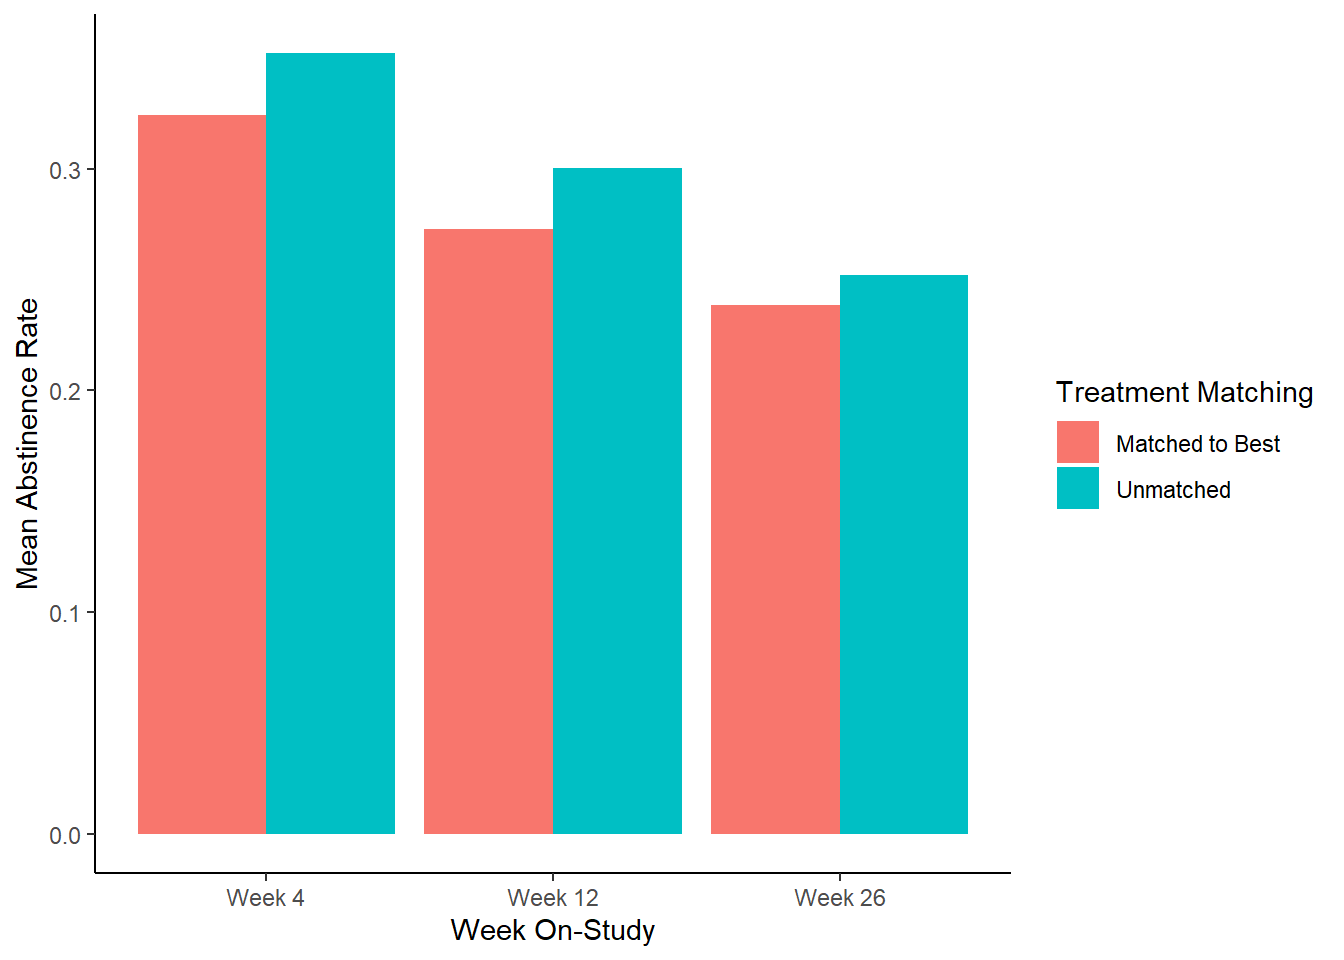

#### 26-week model

There was no significant fixed effect of treatment matching on abstinence (*p* = 0.967). There was a significant fixed effect of time (OR = 0.208, *z* = -10.050, *p* \< 0.001) such that the probability of abstinence declined over time. There was not a significant interaction between treatment matching and time (*p* = 0.402). Supplemental Figure 6 shows the mean abstinence rate by treatment matching at each time point.

``` python
d |> 
  mutate(week_cat = factor(week,
                           levels = c(4, 12, 26),
                           labels = c("Week 4", "Week 12", "Week 26")),
         tx_match = factor(tx_match, 
                           levels = c(TRUE, FALSE),
                           labels = c("Matched to Best", "Unmatched"))) |> 
  group_by(week_cat, tx_match) |> 
  summarize(mean_outcome = mean(outcome_rct_num)) |> 
  ggplot(aes(x = week_cat, y = mean_outcome, fill = tx_match)) +
  geom_col(position = "dodge") +
  labs(
    x = "Week On-Study",
    y = "Mean Abstinence Rate",
    fill = "Treatment Matching"
  )
```

    `summarise()` has grouped output by 'week_cat'. You can override using the
    `.groups` argument.

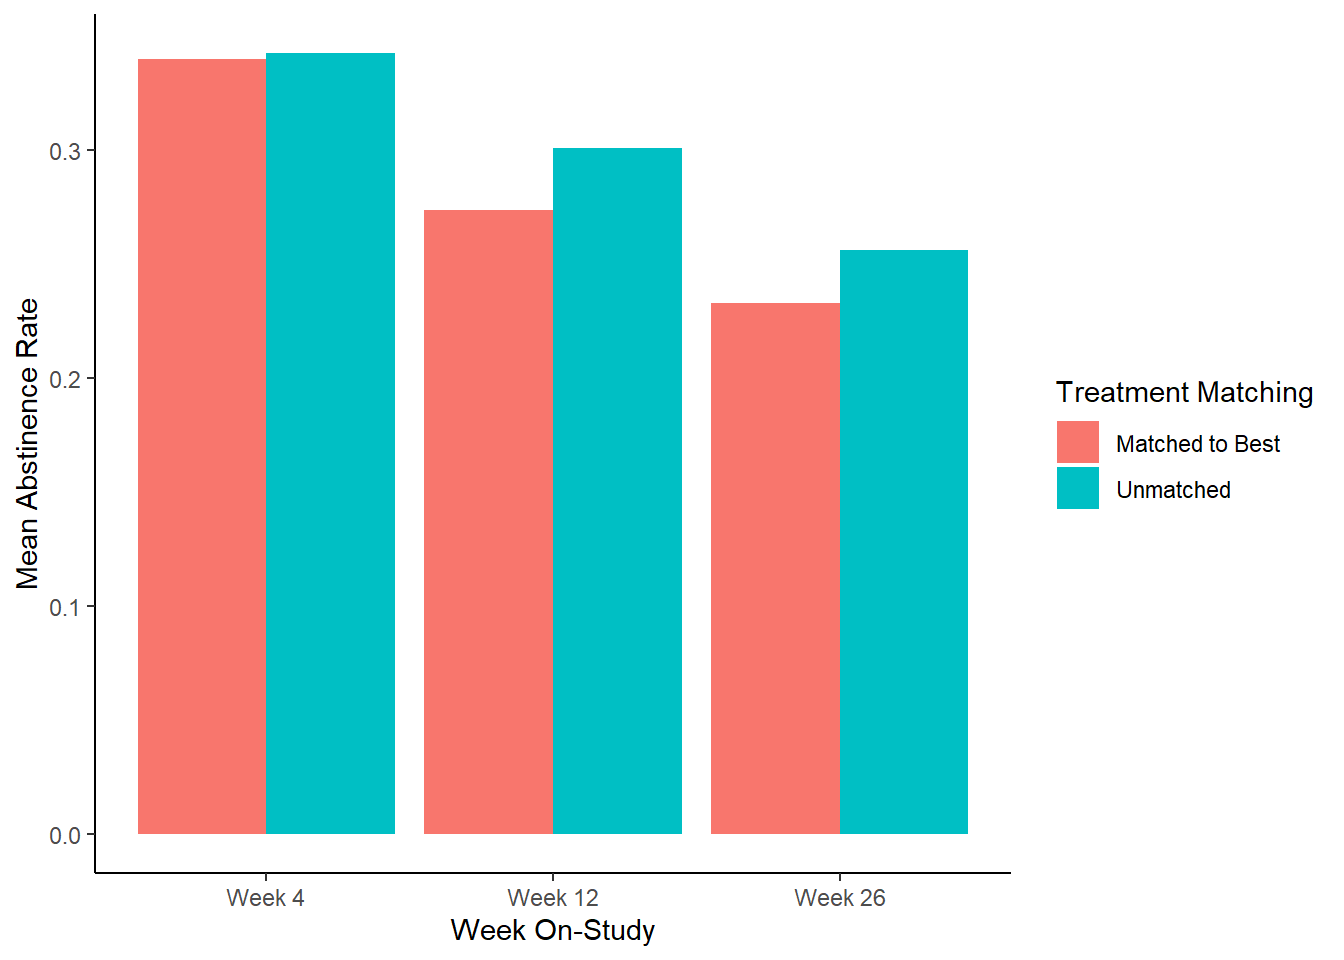